# Safe Absorbing States

Number of Omega-automaton states (including the trap state): 4


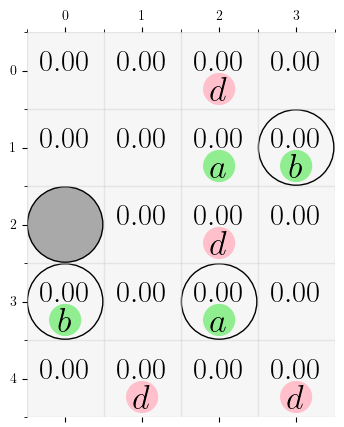

In [42]:
from NN import *
from LTL import *

%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt

# LTL Specification
ltl = '(F G a | F G b) & G !d'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'T'],
['B',  'E',  'E',  'E'],
['T',  'E',  'T',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),       (),     ('d',),()],
[(),       (),     ('a',),('b',)],
[(),       (),     ('d',),()],
[('b',),   (),     ('a',),()],
[(),       ('d',), (),    ('d',)]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('d',):'pink'
}
p = 0.8
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

In [43]:
full_t = "(<> [] a \/ <> [] b) /\ [] ~d"

LTL_formula = parser.parse(full_t)
predicates={'a':[6,14], 'b':[7,12], 'd':[2,10,17,19]}

In [44]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 4, 4)]    0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 5, 4, 32)     544         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 160)          0           ['conv2d_3[0][0]']               
                                                                                            

In [45]:
model(csrl.ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [62]:
temp = np.zeros(20)
temp[:5]=1
temp.std()

0.4330127018922193

In [87]:

num_epochs = 20
training = True
T = [2,4,6,8,10,15,20,30,50,70,100, 150, 200, 350, 400, 450, 500]
K = 3
search_depth = 10

success_rates = []
succes_std = []

for i in T:
    wins = 0
    for epoch in range(num_epochs):

        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, search_depth=search_depth, verbose=4, T=min(20, i), K=3)

        if check_LTL(LTL_formula, trajectory, predicates)[0]:
            wins+=1

        if training and len(action_history)>0:
            x_train = np.array(channeled_states)
            y1_train = np.array(better_policy)
            y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
            model.fit(x_train[:-1], [y1_train, y2_train[:-1]], epochs=20, verbose=0)

    success_rates.append(100*wins/num_epochs)
    temp = np.zeros(num_epochs)
    temp[:wins]=1
    std = np.sqrt(num_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Wins:",wins,"/",num_epochs)
    print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    print("Actions:", action_history)

FAIL: states (if in acc) [None, None]
trajectory: [0, 1]
success ep: 2 / 3
trajectory: [16, 12]
action_history: [0]
state history: [(0, 0, 4, 0), (0, 0, 3, 0)]
----------
success ep: 1 / 3
trajectory: [14, 14]
action_history: [2]
state history: [(0, 0, 3, 2), (0, 0, 3, 2)]
----------
FAIL: states (if in acc) [None]
trajectory: [19]
success ep: 2 / 3
trajectory: [3, 7]
action_history: [1]
state history: [(0, 0, 0, 3), (0, 0, 1, 3)]
----------
success ep: 1 / 3
trajectory: [11, 7]
action_history: [0]
state history: [(0, 0, 2, 3), (0, 0, 1, 3)]
----------
FAIL: states (if in acc) [None, None]
trajectory: [1, 5]
success ep: 2 / 3
trajectory: [16, 12]
action_history: [0]
state history: [(0, 0, 4, 0), (0, 0, 3, 0)]
----------
FAIL: states (if in acc) [None, None]
trajectory: [4, 5]
FAIL: states (if in acc) [None, None]
trajectory: [8, 8]
FAIL: states (if in acc) [None]
trajectory: [2]
trajectory: [2]
action_history: []
state history: [(0, 0, 0, 2)]
----------
FAIL: states (if in acc) [None, 

Text(0.5, 1.0, 'MCTS (search depth=10) performance results on the first case study, P=0.8')

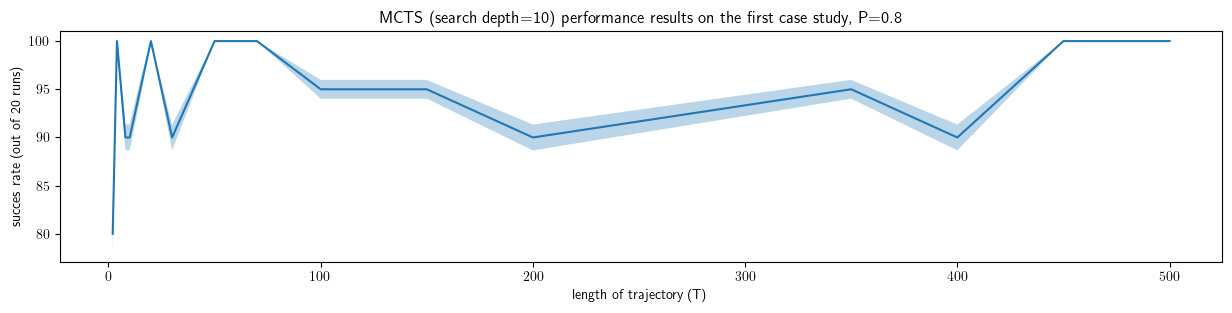

In [89]:
succes_std = np.array(succes_std)

plt.figure(figsize=(15,3))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 20 runs)")
plt.title("MCTS (search depth="+str(search_depth)+") performance results on the first case study, P="+str(p))

In [6]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_agent(t)>

In [100]:
Q=csrl.q_learning(T=100,K=100000)
np.save(f'Q1_{p}', Q)

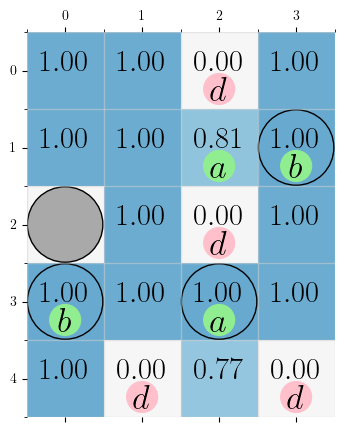

In [101]:
value=np.max(Q,axis=4)
np.save(f'value1_{p}', value)
# csrl.plot(value,iq=(0,0),save='safe_absorbing_states_values.pdf')
csrl.plot(value,iq=(0,0))

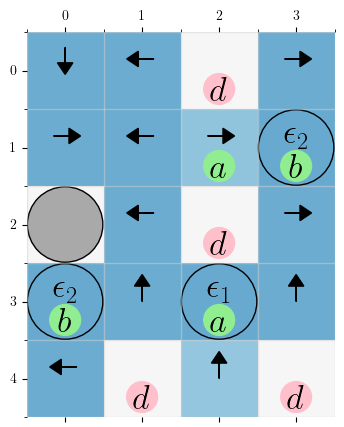

In [102]:
policy=np.argmax(Q,axis=4)
np.save(f'policy1_{p}', policy)
# csrl.plot(value,policy,iq=(0,0),save='safe_absorbing_states_policy.pdf')
csrl.plot(value,policy,iq=(0,0))

Load stuff

In [5]:
p=0.8
Q = np.load(f'Q1_{p}.npy')
value = np.load(f'value1_{p}.npy')
policy = np.load(f'policy1_{p}.npy')

In [49]:
episodes, rewards = csrl.run_Q_test(policy, LTL_formula, predicates, start=(0,0),T=100, runs=1, verbose=3)

Running 1 simulations with 100 time-steps...


interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

episode 0 rew: False
states (if in acc) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Test finished with:
	success rate: 0 / 1 = 0.0


In [26]:
np.sqrt(1000*np.var(rew)), np.mean(rew)

(15.68537535413163, 0.563)

In [113]:
rewards_mean = []
rewards_std = []
n_runs = 100

x = range(1,502,20)
for i in x:
    episodes, rew = csrl.run_Q_test(policy, LTL_formula, predicates, T=i, runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 100 simulations with 1 time-steps...
Test finished with:
	success rate: 22 / 100 = 0.22
Running 100 simulations with 21 time-steps...
Test finished with:
	success rate: 43 / 100 = 0.43
Running 100 simulations with 41 time-steps...
Test finished with:
	success rate: 49 / 100 = 0.49
Running 100 simulations with 61 time-steps...
Test finished with:
	success rate: 56 / 100 = 0.56
Running 100 simulations with 81 time-steps...
Test finished with:
	success rate: 49 / 100 = 0.49
Running 100 simulations with 101 time-steps...
Test finished with:
	success rate: 54 / 100 = 0.54
Running 100 simulations with 121 time-steps...
Test finished with:
	success rate: 61 / 100 = 0.61
Running 100 simulations with 141 time-steps...
Test finished with:
	success rate: 59 / 100 = 0.59
Running 100 simulations with 161 time-steps...
Test finished with:
	success rate: 53 / 100 = 0.53
Running 100 simulations with 181 time-steps...
Test finished with:
	success rate: 61 / 100 = 0.61
Running 100 simulations wi

Text(0.5, 1.0, 'CSRL performance results on the first case study, P=0.8')

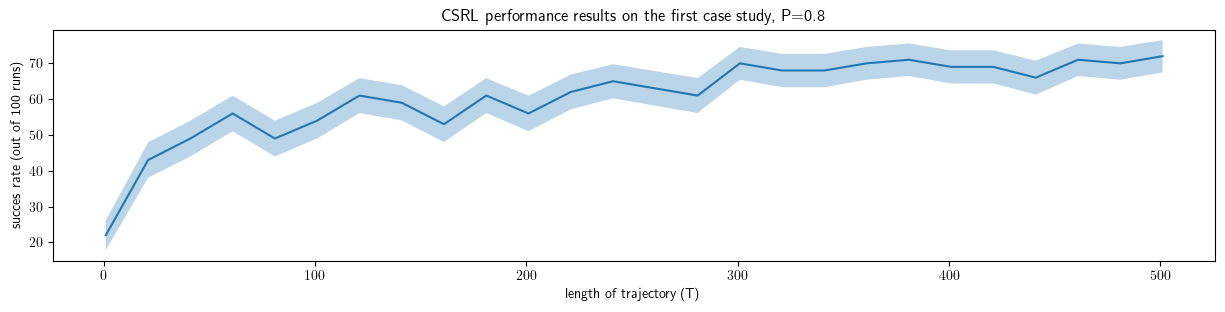

In [114]:
plt.figure(figsize=(15,3))
plt.fill_between(x, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(x, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 100 runs)")
plt.title("CSRL performance results on the first case study, P="+str(p))

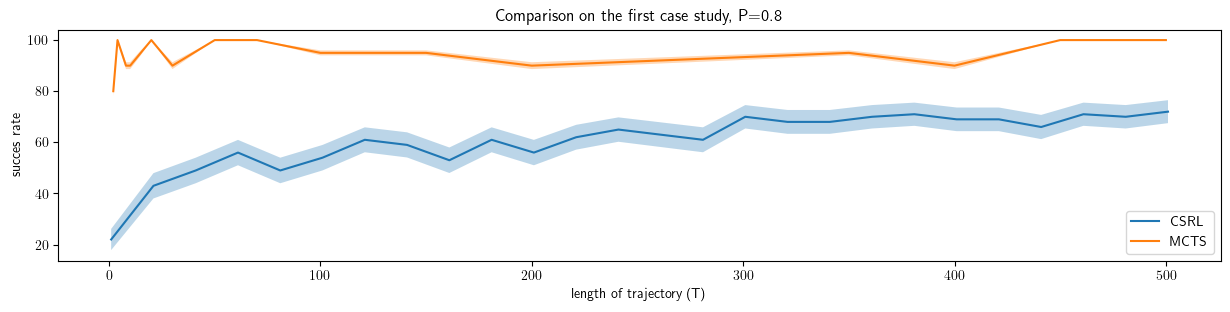

In [116]:
plt.figure(figsize=(15,3))

plt.fill_between(x, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(x, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the first case study, P="+str(p))

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="MCTS")
plt.legend()

In [11]:
rewards_backup = rewards.copy()

In [7]:
episodes, rewards = csrl.run_Q_test(policy, LTL_formula, predicates, start=(0,0),T=100, runs=1, verbose=4, animation='True')

Running 1 simulations with 100 time-steps...


interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

episode 0 rew: False
states (if in acc) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Test finished with:
	success rate: 0 / 1 = 0.0


In [15]:
policy.shape

(1, 4, 5, 4)

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_agent(t)>

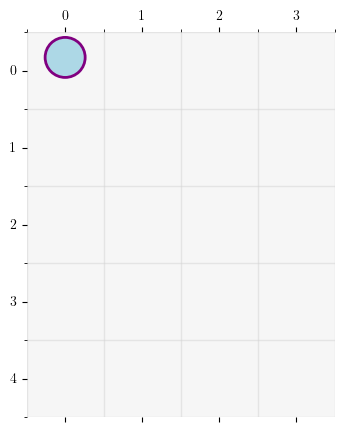

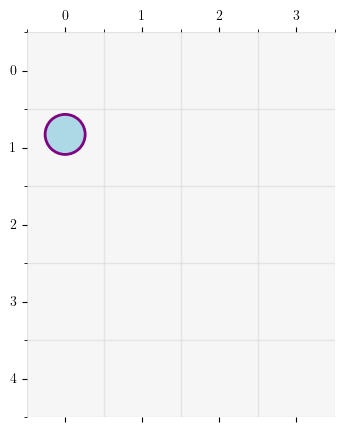

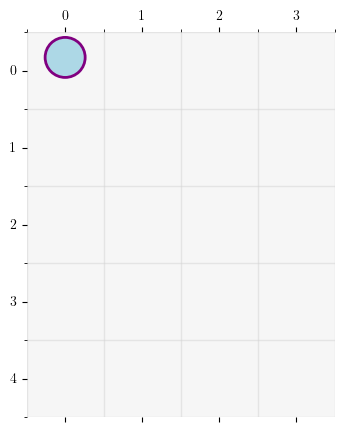

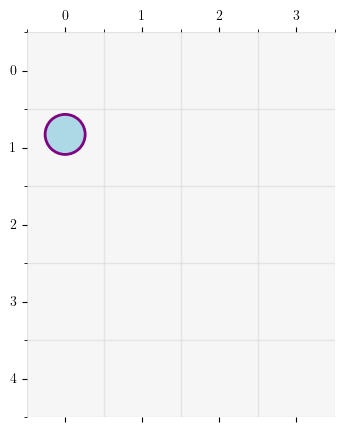

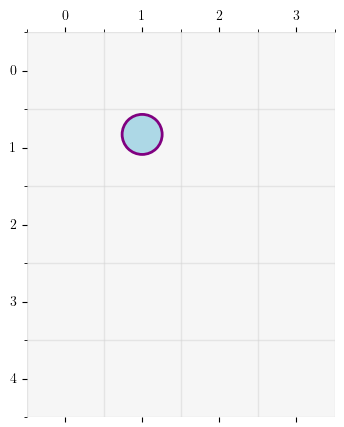

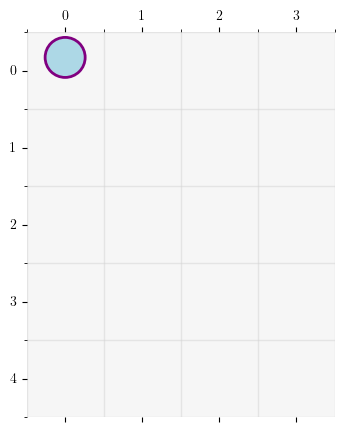

In [14]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=episodes[0][t][2:],policy=policy, save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=len(episodes[0])-1)
interact(plot_agent,t=t)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=2.)
sns.set_style({'font.family': 'Times New Roman'})

# Maximal probabilities
pmax = np.array([
    [1.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 0.8, 1.0],
    [0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0],
    [1.0, 0.0, 0.8, 0.0]
])

R = 100  # Repetitions
K_max = 18  # Log2 of the maximum episode length 
e = np.zeros((K_max, R))  # Error matrix
for k,K in enumerate(2**np.arange(K_max)):
    for i in range(R):
        Q=csrl.q_learning(T=100,K=K)
        value=np.max(Q,axis=4)
        e[k,i] = np.linalg.norm(value[0,0]-pmax)

mean = np.mean(e,axis=1)
std = np.std(e,axis=1)

# Plot the errors
K_min = 10  #  Log2 of the minimum episode length to be plotted
plt.figure(figsize=(6,6))
plt.errorbar(np.arange(K_min,K_max),mean[K_min:],yerr=std[K_min:],capsize=6,capthick=2,linewidth=3)
plt.xlabel(r'Number of Episodes')
plt.xticks(np.arange(K_min,K_max),['$2^{'+str(i)+'}$' for i in np.arange(K_min,K_max)])
plt.ylabel('L2 Norm of Errors')
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid(True)
plt.gca().xaxis.set_label_coords(0.4, -0.14)
plt.gca().set_facecolor('whitesmoke')
# plt.savefig('convergence.pdf',bbox_inches='tight')

KeyboardInterrupt: 